In [1]:
import os

folder_path = "../sample_audio"  # Replace with the actual path to your folder

# Get a list of all files in the folder
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

# Print the list of file names relative to the root directory
for file in file_list:
    print(os.path.relpath(file, folder_path))


sg_parliament_4h.mp3
cna_sg_23min.mp3
sg_parliament_20min.mp3
sg_documentary_45min.mp3


In [23]:
import whisperx
import gc 

with open(r'../keys/hugging_face.txt', 'r') as fp:
    # read all lines using readline()
    lines = fp.readlines()
    for line in lines:
        HF_TOKEN = line

language = 'en'
device = "cuda" 
audio_file = "../sample_audio/sg_parliament_20min.mp3"
batch_size = 16 # reduce if low on GPU mem
compute_type = "float16" # change to "int8" if low on GPU mem (may reduce accuracy)

def whisperx_transcribe(audio_file):
# 1. Transcribe with original whisper (batched)
    model = whisperx.load_model("small", device, compute_type=compute_type, language = language)

    # save model to local path (optional)
    # model_dir = "/path/"
    # model = whisperx.load_model("large-v2", device, compute_type=compute_type, download_root=model_dir)

    audio = whisperx.load_audio(audio_file)
    result = model.transcribe(audio, batch_size=batch_size, language = language)
    print(result["segments"]) # before alignment

    # delete model if low on GPU resources
    # import gc; gc.collect(); torch.cuda.empty_cache(); del model

    # 2. Align whisper output
    model_a, metadata = whisperx.load_align_model(language_code='en', device=device)
    result = whisperx.align(result["segments"], model_a, metadata, audio, device, return_char_alignments=False)

    print(result["segments"]) # after alignment

    # delete model if low on GPU resources
    # import gc; gc.collect(); torch.cuda.empty_cache(); del model_a

    # 3. Assign speaker labels
    diarize_model = whisperx.DiarizationPipeline(use_auth_token=HF_TOKEN, device=device)

    # add min/max number of speakers if known
    diarize_segments = diarize_model(audio, min_speakers = 5, max_speakers = 11)
    # diarize_model(audio, min_speakers=min_speakers, max_speakers=max_speakers)

    result = whisperx.assign_word_speakers(diarize_segments, result)
    print(diarize_segments)
    print(result["segments"]) # segments are now assigned speaker IDs
    return result

In [24]:
result = whisperx_transcribe(audio_file)
# for segment in result['segments']:
#     for word in segment['words']:
#         print(word)

RuntimeError: CUDA failed with error out of memory

In [63]:
import os

# Define the directory to store transcripts
transcripts_dir = "../transcripts"

# Find the next available transcript file number
transcript_num = 1
while True:
    transcript_filename = f"whisperx_transcript{str(transcript_num).zfill(3)}.txt"
    if not os.path.exists(os.path.join(transcripts_dir, transcript_filename)):
        break
    transcript_num += 1

speakerID_speech = {}
sentence_list = []

# Open the transcript file for writing
with open(os.path.join(transcripts_dir, transcript_filename), "w") as transcript_file:
    prev_speaker = None
    for segment in result['segments']:
        for word in segment['words']:
            if 'speaker' in word and word['speaker'] != prev_speaker:
                transcript_file.write(f"\n\n{word['speaker']}  {word['start']}\n")
                transcript_file.write(word['word'] + " ")
                prev_speaker = word['speaker']
            else:
                transcript_file.write(word['word'] + " ")

# Print the filename of the created transcript file
print(f"Transcript saved as: {transcript_filename}")

Transcript saved as: whisperx_transcript003.txt


In [22]:
file = open('myfile.txt', 'w')
file.close()


In [44]:
speaker_ids = []
start_time = []
speeches = []

prev_speaker = None
for segment in result['segments']:
    for word in segment['words']:
        if 'speaker' in word and word['speaker'] != prev_speaker:
            speaker_ids.append(word['speaker'])
            start_time.append(word['start'])
            speeches.append(word['word'] + " ")
            prev_speaker = word['speaker']
        else:
            # If the word does not indicate a speaker change, append to the previous speaker's speech
            speeches[-1] += word['word'] + " "
            if 'end' in word:
                end_of_speech = word['end']
end_time = start_time[1:] + [end_of_speech]

In [45]:
duration = []

# Iterate over the indices of start_time and end_time
for i in range(len(start_time)):
    # Calculate the duration and append it to the duration list
    duration.append(float(end_time[i]) - float(start_time[i]))

In [46]:
import pandas as pd
data = {
    'speaker_id': speaker_ids,
    'duration': duration,
    'speech': speeches
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data)

# Display the DataFrame
display(df)

,speaker_id,duration,speech
0,SPEAKER_01,11.345,for the first time on television. Five familie...
1,SPEAKER_04,2.521,"Over four months, we filmed in Bukit Merah, ho..."
2,SPEAKER_01,18.814,of the neediest people in Singapore. We follow...
3,SPEAKER_09,10.109,Twins only left for one bottle for one baby on...
4,SPEAKER_05,2.722,I just wanted to get out from this place.
...,...,...,...
95,SPEAKER_09,61.444,being violent is a way of protecting myself. Y...
96,SPEAKER_05,11.005,"He's the only one that I have now, Abby. Whate..."
97,SPEAKER_07,2.521,you get trapped by your own circumstances?
98,SPEAKER_09,16.343,I was very stressed when you paid for it. I ha...


In [52]:
speaker_totals = df.groupby('speaker_id')['duration'].sum().sort_values(ascending=False)

# Print the total time each speaker spoke

speaker_id
SPEAKER_09    671.899
SPEAKER_01    371.837
SPEAKER_10    141.540
SPEAKER_08    106.296
SPEAKER_03     39.144
SPEAKER_06     26.948
SPEAKER_07     17.213
SPEAKER_02     15.581
SPEAKER_00     15.433
SPEAKER_05     13.727
SPEAKER_04      4.902
Name: duration, dtype: float64


In [58]:
max_speaker = speaker_totals.idxmax()
min_speaker = speaker_totals.idxmin()
max_duration = speaker_totals[max_speaker]
min_duration = speaker_totals[min_speaker]

# Average speaking time per speaker
average_duration = speaker_totals.mean()

print(f"Spoke the most: {max_speaker} ({max_duration:.2f} seconds)")
print(f"Spoke the least: {min_speaker} ({min_duration:.2f} seconds)")
print(f"Average speaking time: {average_duration:.2f} seconds")

Spoke the most: SPEAKER_09 (671.90 seconds)
Spoke the least: SPEAKER_04 (4.90 seconds)
Average speaking time: 129.50 seconds


In [62]:
meta_data = {'max_speaker_id': max_speaker, 'max_speaker_duration':max_duration.round(2), 'min_speaker_id': min_speaker, 'min_speaker':min_duration.round(2), "average_duration":average_duration.round(2), 'total_speaker': len(speaker_totals)}
print(meta_data)

{'max_speaker_id': 'SPEAKER_09', 'max_speaker_duration': 671.9, 'min_speaker_id': 'SPEAKER_04', 'min_speaker': 4.9, 'average_duration': 129.5, 'total_speaker': 11}


In [5]:
# !pip instal wordcloud
# !pip install nltk
# !pip install textblob
import nltk
nltk.download('punkt')  # Download sentence tokenizer
nltk.download('averaged_perceptron_tagger')  # Download POS tagger
from nltk import word_tokenize, pos_tag, FreqDist
from nltk.corpus import stopwords
from textblob import TextBlob  # Sentiment analysis
from collections import Counter  # Counter for trigrams
from wordcloud import WordCloud  # Wordcloud generation
import matplotlib.pyplot as plt

with open("../transcripts/whisperx_transcript002.txt", "r") as f:
    text = f.read()
sentences = nltk.sent_tokenize(text)

filtered_tokens = [[word.lower() for word in word_tokenize(sentence) if word.lower() not in stopwords.words('english') and word.lower().isalnum()] for sentence in sentences]

# Flatten the list of tokens
all_words = [word for sentence_words in filtered_tokens for word in sentence_words]

# Perform part-of-speech tagging
pos_tags = pos_tag(all_words)

# Extract trigrams (collocations)
trigrams = nltk.trigrams(all_words)

# Count frequencies of words
word_freq = FreqDist(all_words)

# Generate word cloud for meaningful words
wordcloud = WordCloud().generate_from_frequencies(word_freq)


[nltk_data] Downloading package punkt to
[nltk_data]     /media/mldadmin/home/s123mdg310_03/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /media/mldadmin/home/s123mdg310_03/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [12]:
from nltk.corpus import wordnet

# Define noun tags based on NLTK's tagset
NOUN_TAGS = ['NN', 'NNS', 'NNP', 'NNPS']  # Common noun tags (singular, plural, proper singular, proper plural)
words = nltk.tokenize.word_tokenize(text)
words = [word.lower() for word in words if word not in stopwords.words('english')]
# Filter most frequent nouns
fdist = nltk.FreqDist(words)
most_freq_nouns = [w for w, c in fdist.most_common(40)
                   if nltk.pos_tag([w])[0][1] in NOUN_TAGS]

print(most_freq_nouns) # not very useful

['i', 'chuan', 'feel', 'time', 'speaker_03', 'speaker_00', 'want', 'bit', 'husband', 'friend', 'family', 'thank', 'jeremy']


Visual Analysis
Number of words excluding punctuation & stopwords: 1980


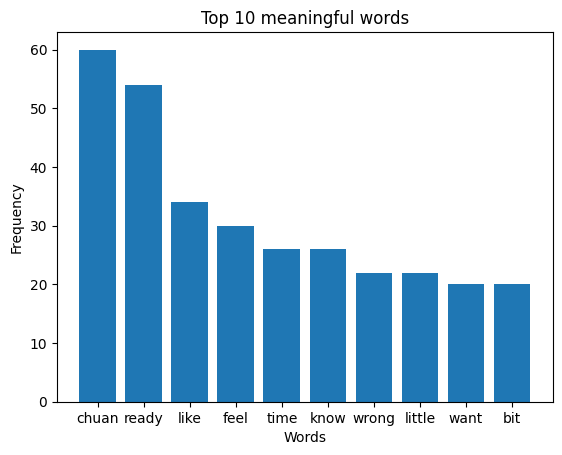

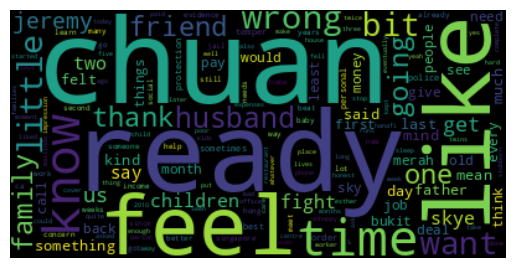

Graph Analysis
Num questions asked: 99
Most commonly asked questions: Are you ready? ( 23 asked)


In [19]:
# Visual Analysis
print("Visual Analysis")
# Number of words excluding punctuation & stopwords
filtered_words_no_punct = [word for word in all_words if word.isalnum()]
num_words_no_punct = len(filtered_words_no_punct)
print("Number of words excluding punctuation & stopwords:", num_words_no_punct)
# Visual frequency chart of top 10 meaningful words (use matplotlib)
top_words = word_freq.most_common(10)
plt.bar(range(len(top_words)), [freq for word, freq in top_words], align='center')
plt.xticks(range(len(top_words)), [word for word, freq in top_words])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 10 meaningful words')
plt.show()
# Visual word cloud of most meaningful used words
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Graph Analysis
print("Graph Analysis")
num_questions_asked = sum(1 for sentence in sentences if '?' in sentence)
print("Num questions asked:", num_questions_asked)
speaker_questions = Counter([line.split(":")[0].strip() for line in sentences if '?' in line])
speaker_answers = Counter([line.split(":")[0].strip() for line in sentences if '?' not in line and line.strip() != ''])
most_questions_asked = max(speaker_questions, key=speaker_questions.get)
most_answers_given = max(speaker_answers, key=speaker_answers.get)
print("Most commonly asked questions:", most_questions_asked, "(", speaker_questions[most_questions_asked], "asked)")